In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import astroML
from tqdm import tqdm

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# astropy
from astropy import units as u
from astropy import constants

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

import dynesty

import sklearn
from sklearn import manifold
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE

# Regression
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.gaussian_process import GaussianProcessRegressor

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Classification
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from astroML.utils import split_samples, completeness_contamination

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

## Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.




In [47]:
import h5py 
file = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5','r')

In [48]:
N = 100000 # data sample lenght
idx = np.random.choice(np.arange(0,len(file['det'])),N) # select N random data from the file

data = np.empty([len(file),N])
keys = np.empty(len(file),dtype=object)

for i in tqdm(range(len(file))):
    kw = list(file.keys())[i]
    data[i] = file[kw][()][np.sort(idx)]
    keys[i] = kw

file.close()

100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


In [49]:
# build the arrays for the classification

X = data[(keys!='snr') & (keys!='det')].T
y = data[keys=='det'].T
det_idx = y[:,0]==1
new_keys = keys[(keys!='snr') & (keys!='det')]

# divide the dataset in train and test:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.25,train_size=0.75)

Let's have a look at the single-feature distributions:

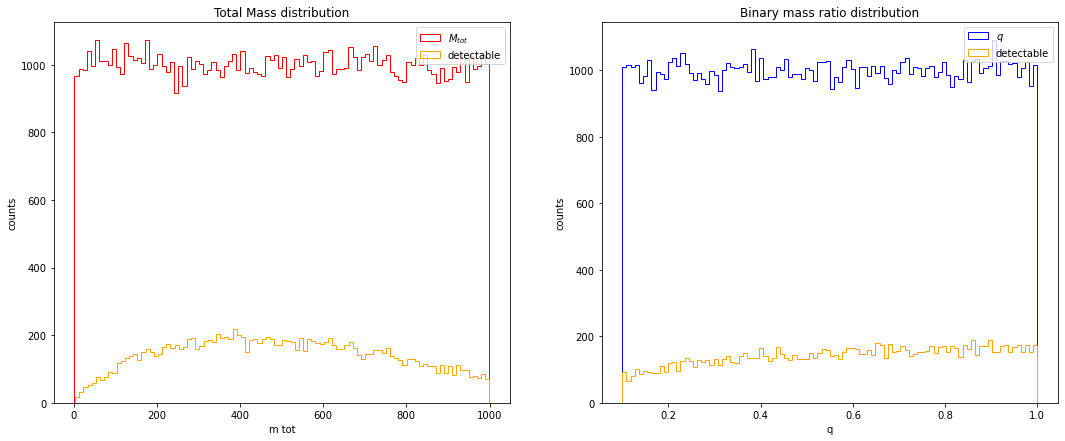

In [50]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,7))

ax[0].hist(X[:,new_keys=='mtot'],color='red',bins=100,histtype='step',label='$M_{tot}$')
ax[0].hist(X[:,new_keys=='mtot'][det_idx],color='orange',bins=100,histtype='step',label='detectable')

ax[1].hist(X[:,new_keys=='q'],color='blue',bins=100,histtype='step',label='$q$')
ax[1].hist(X[:,new_keys=='q'][det_idx],color='orange',bins=100,histtype='step',label='detectable')

ax[0].set_xlabel('m tot')
ax[0].set_ylabel('counts')
ax[0].set_title('Total Mass distribution')
ax[0].legend()

ax[1].set_xlabel('q')
ax[1].set_ylabel('counts')
ax[1].set_title('Binary mass ratio distribution')
ax[1].legend()

plt.show()

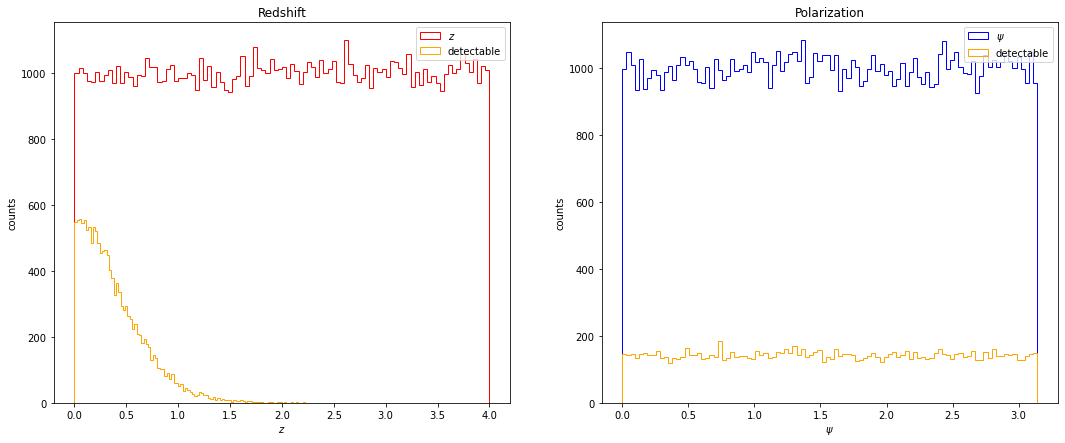

In [51]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,7))

ax[0].hist(X[:,new_keys=='z'],color='red',bins=100,histtype='step',label='$z$')
ax[0].hist(X[:,new_keys=='z'][det_idx],color='orange',bins=100,histtype='step',label='detectable')
ax[1].hist(X[:,new_keys=='psi'],color='blue',bins=100,histtype='step',label='$\psi$')
ax[1].hist(X[:,new_keys=='psi'][det_idx],color='orange',bins=100,histtype='step',label='detectable')

ax[0].set_xlabel('$z$')
ax[0].set_ylabel('counts')
ax[0].set_title('Redshift')
ax[0].legend()

ax[1].set_xlabel(r'$\psi$')
ax[1].set_ylabel('counts')
ax[1].set_title('Polarization')
ax[1].legend()

plt.show()

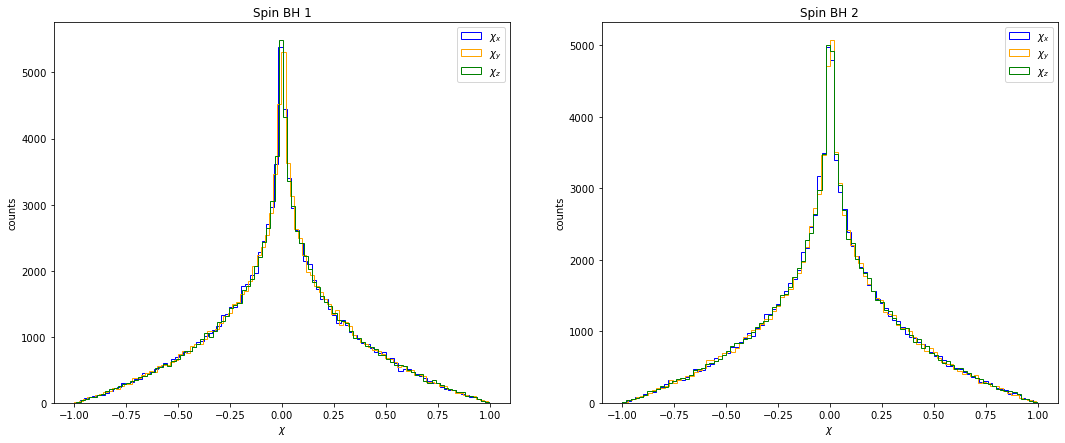

In [52]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,7))

ax[0].hist(X[:,new_keys=='chi1x'],color='blue',bins=100,histtype='step',label='$\chi_x$')
ax[0].hist(X[:,new_keys=='chi1y'],color='orange',bins=100,histtype='step',label='$\chi_y$')
ax[0].hist(X[:,new_keys=='chi1z'],color='green',bins=100,histtype='step',label='$\chi_z$')

ax[1].hist(X[:,new_keys=='chi2x'],color='blue',bins=100,histtype='step',label='$\chi_x$')
ax[1].hist(X[:,new_keys=='chi2y'],color='orange',bins=100,histtype='step',label='$\chi_y$')
ax[1].hist(X[:,new_keys=='chi2z'],color='green',bins=100,histtype='step',label='$\chi_z$')

ax[0].set_title('Spin BH 1')
ax[0].legend()
ax[0].set_xlabel('$\chi$')
ax[0].set_ylabel('counts')

ax[1].set_title('Spin BH 2')
ax[1].set_xlabel('$\chi$')
ax[1].set_ylabel('counts')
ax[1].legend()
plt.show()

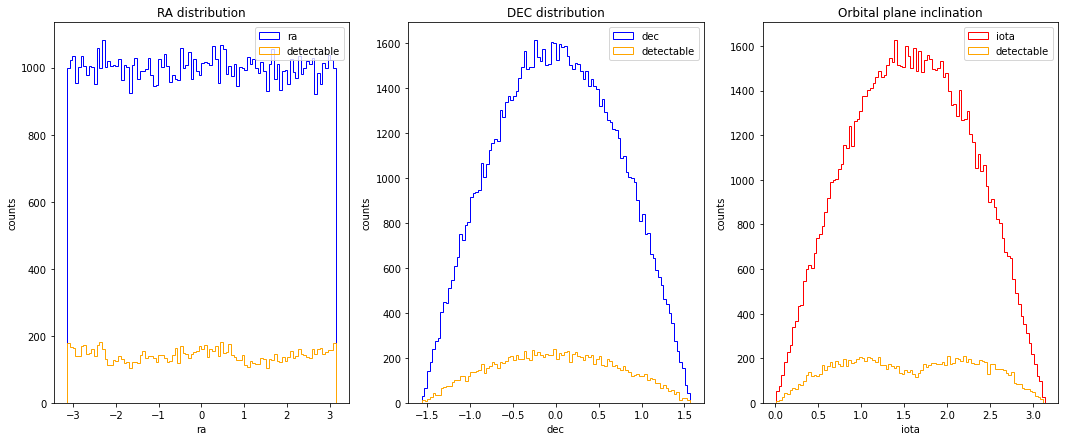

In [53]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,7))

ax[0].hist(X[:,new_keys=='ra'],color='blue',bins=100,histtype='step',label='ra')
ax[0].hist(X[:,new_keys=='ra'][det_idx],color='orange',bins=100,histtype='step',label='detectable')
ax[1].hist(X[:,new_keys=='dec'],color='blue',bins=100,histtype='step',label='dec')
ax[1].hist(X[:,new_keys=='dec'][det_idx],color='orange',bins=100,histtype='step',label='detectable')
ax[2].hist(X[:,new_keys=='iota'],color='red',bins=100,histtype='step',label='iota')
ax[2].hist(X[:,new_keys=='iota'][det_idx],color='orange',bins=100,histtype='step',label='detectable')


ax[0].set_xlabel('ra')
ax[0].set_ylabel('counts')
ax[0].set_title('RA distribution')
ax[0].legend()

ax[1].set_xlabel('dec')
ax[1].set_ylabel('counts')
ax[1].set_title('DEC distribution')
ax[1].legend()

ax[2].set_xlabel('iota')
ax[2].set_ylabel('counts')
ax[2].set_title('Orbital plane inclination')
ax[2].legend()


plt.show()

From the above distributions it seems that the mass of total mass of the binary and the redshift are the two most important feature for the classification

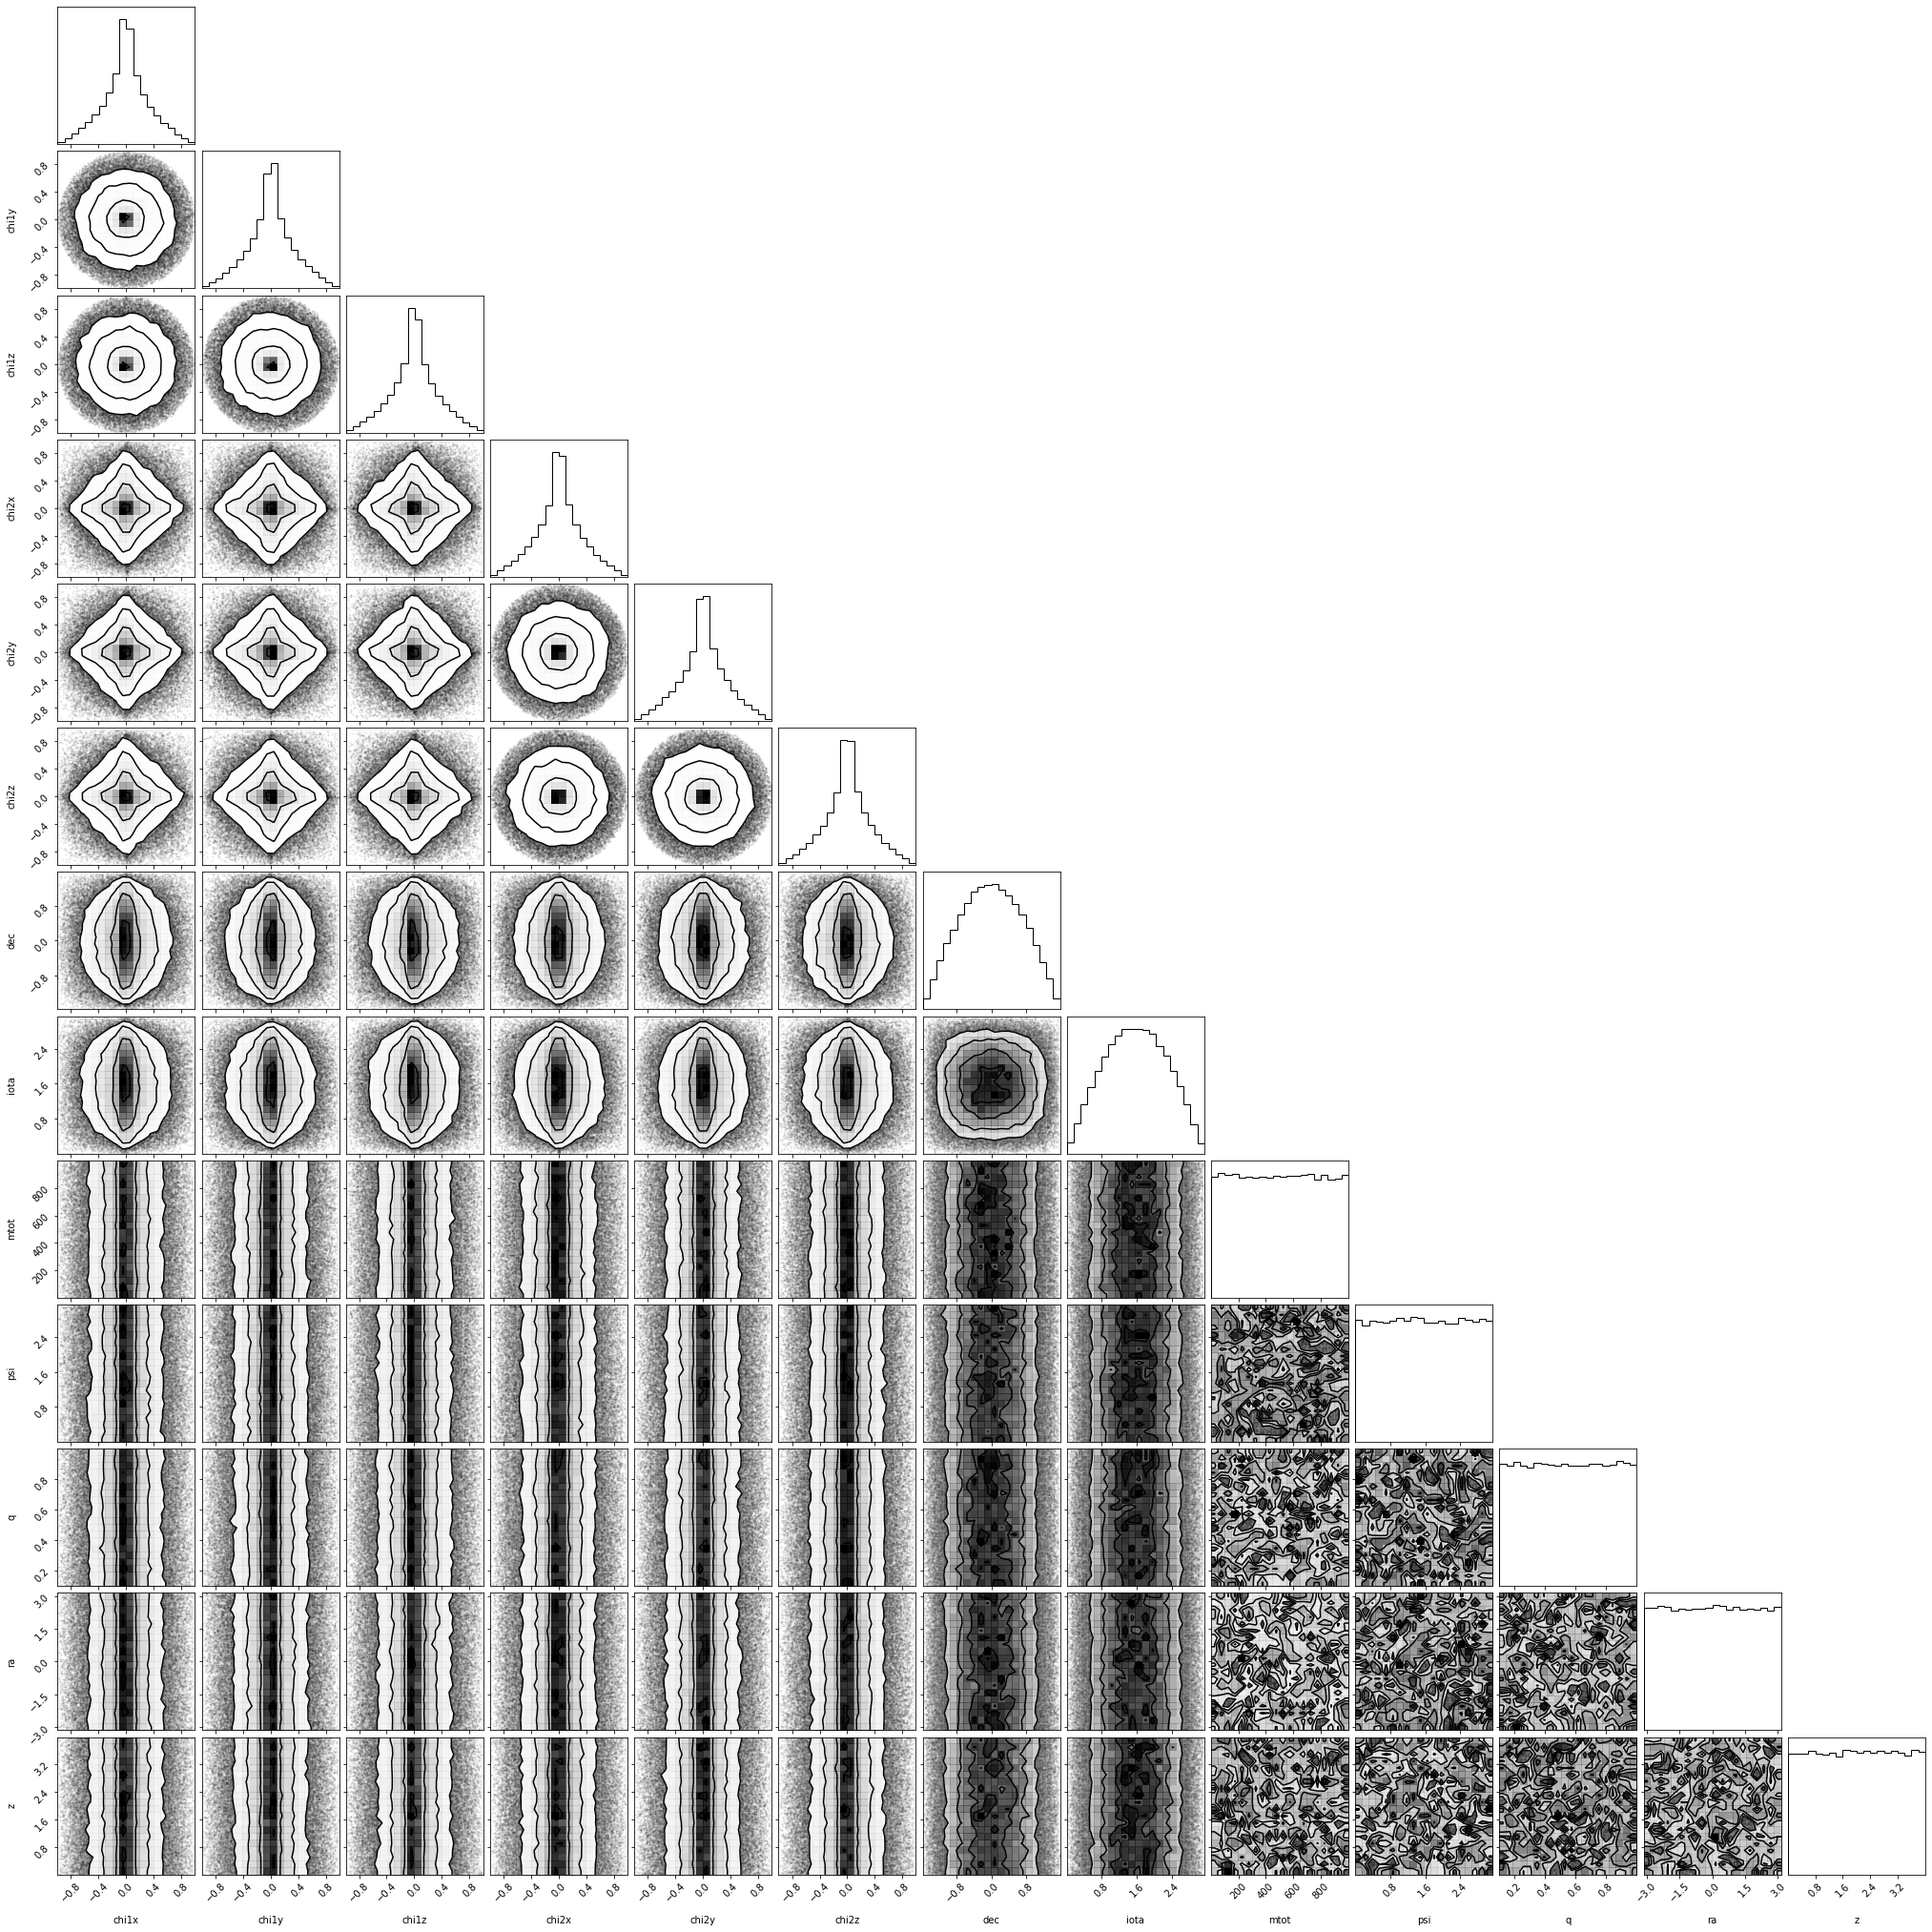

In [54]:
corner.corner(X,labels=new_keys);

#### Cross-vallidation to determine the best hyperparameters

In [55]:
def error_func(y_true, y_m):
    N = len(y_true)
    return np.sqrt(1/N * np.sum((y_true-y_m)**2)) 

def cross_validation(X,y,model,split_method):
    "computes and returns the cross validation error and the training error, given the datasets and the model to validate"
    
    split = split_method # sample splitting
    
    err_train_i = []
    err_cv_i = []
    
    # iterating over the n_splits
    for train, test in split.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_true_train = y[train]
        
        y_cv = model.predict(X[test])
        y_true_cv = y[test]
    
        # compute the errors on the training and cross-validation set for a given set
        err_train_i.append(error_func(y_true_train,y_train)) # compute the error on the training set
        err_cv_i.append(error_func(y_true_cv,y_cv)) # compute the error on the validation set
   
    err_train = np.mean(err_train_i)
    err_cv = np.mean(err_cv_i)
    
    return err_train, err_cv

#### Random-Forest

19


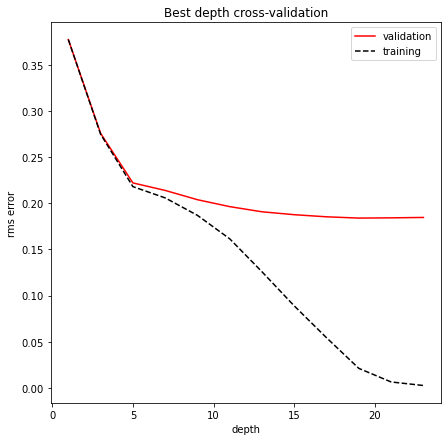

In [56]:
depth = np.arange(1,25)[::2]

rms_val = np.zeros(len(depth))
rms_train = np.zeros(len(depth))

for d,i in zip(depth,np.arange(len(depth))):
    n_splits = 5
    split_method = KFold(n_splits)
    
    model = RandomForestClassifier(n_estimators=100,max_depth=d,random_state=0,n_jobs=-1)
    
    rms_train[i],rms_val[i] = cross_validation(X_train,y_train[:,0],model,split_method) # CV only on the training set

best_depth = depth[np.argmin(rms_val)]
print(best_depth)

fig = plt.figure(figsize=(7,7))

plt.plot(depth,rms_val,label='validation',color='red')
plt.plot(depth,rms_train,label='training',color='black',ls='--')
plt.ylabel('rms error')
plt.xlabel('depth')
plt.title('Best depth cross-validation')
plt.legend()

Choose depth=10 to avoid overfitting

In [76]:
clf_rf = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=0)
clf_rf.fit(X_train,y_train[:,0])

y_pred_rf = clf_rf.predict(X_test)
y_prob_rf = clf_rf.predict_proba(X_test)

##### Accuracy of the classification

In [77]:
completeness_rf, contamination_rf = astroML.utils.completeness_contamination(y_pred_rf, y_test[:,0])

print("completeness", completeness_rf)
print("contamination", contamination_rf)

completeness 0.8094701240135288
contamination 0.09571788413098237


In [78]:
accuracy_rf = accuracy_score(y_test[:,0],y_pred_rf)

print('accuracy random forest:',accuracy_rf)

accuracy random forest: 0.9608


In [79]:
confusion_matrix(y_test[:,0],y_pred_rf)

array([[21148,   304],
       [  676,  2872]], dtype=int64)

##### Learning curves

In [80]:
# learning curves
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(clf_rf, X, y[:,0], train_sizes=np.linspace(0.1, 1,10),
                                                                 scoring="neg_mean_squared_error", cv=10)

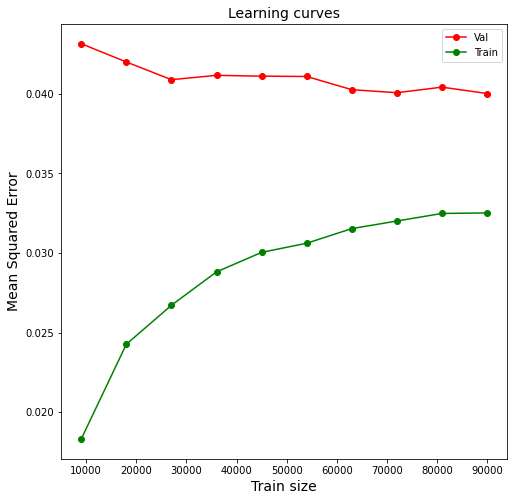

In [81]:
fig = plt.figure(figsize=(8, 8))

plt.plot(train_sizes_rf, -test_scores_rf.mean(1), 'o-', color="r", label="Val")
plt.plot(train_sizes_rf, -train_scores_rf.mean(1), 'o-', color="g", label="Train")
                   
plt.xlabel("Train size",fontsize=14)
plt.ylabel("Mean Squared Error",fontsize=14)
plt.title('Learning curves',fontsize=14)
plt.legend(loc="best")
#plt.ylim(0,200)
#plt.xscale('log')
#plt.yscale('log')

It is not necessary to increase drastically the amount of data in our analysis.

### Bagged decision tree

8


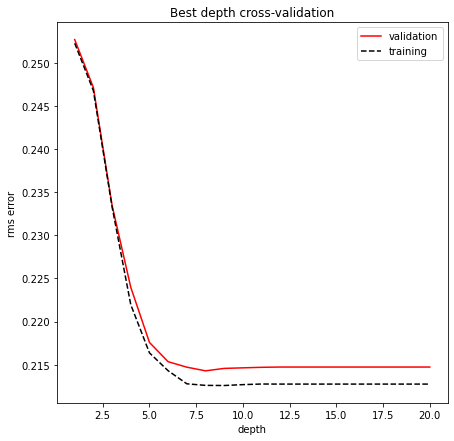

In [68]:
# cross validation to determine the best depth

depth = np.arange(1, 21)

rms_val_bag = np.zeros(len(depth))
rms_train_bag = np.zeros(len(depth))

for d in depth:
    n_splits = 5
    split_method = KFold(n_splits)
    
    model = BaggingClassifier(DecisionTreeClassifier(random_state=42,max_depth=d), 
                            n_estimators=100, max_samples=500, bootstrap=True, random_state=42, n_jobs=-1)
    
    rms_train_bag[d-1],rms_val_bag[d-1] = cross_validation(X_train,y_train[:,0],model,split_method)

best_depth_bag = depth[np.argmin(rms_val_bag)]
print(best_depth_bag)

fig = plt.figure(figsize=(7,7))

plt.plot(depth,rms_val_bag,label='validation',color='red')
plt.plot(depth,rms_train_bag,label='training',color='black',ls='--')
plt.ylabel('rms error')
plt.xlabel('depth')
plt.title('Best depth cross-validation')
plt.legend()

In [69]:
# Bagged Decision Tree

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42,max_depth=best_depth_bag), 
                            n_estimators=100, max_samples=500, bootstrap=True, random_state=42, n_jobs=-1)

bag_clf.fit(X_train,y_train[:,0])

y_pred_bag = bag_clf.predict(X_test)
y_prob_bag = bag_clf.predict_proba(X_test)

##### Accuracy of the classification

In [70]:
completeness_bag, contamination_bag = astroML.utils.completeness_contamination(y_pred_bag, y_test[:,0])

print("completeness", completeness_bag)
print("contamination", contamination_bag)

completeness 0.7970687711386697
contamination 0.1260815822002472


In [71]:
accuracy_bag = accuracy_score(y_test[:,0],y_pred_bag)

print('accuracy bagging:',accuracy_bag)

accuracy bagging: 0.95488


In [72]:
confusion_matrix(y_test[:,0],y_pred_bag)

array([[21044,   408],
       [  720,  2828]], dtype=int64)

In [73]:
# learning curves
train_sizes_bag, train_scores_bag, test_scores_bag = learning_curve(bag_clf, X, y[:,0], train_sizes=np.linspace(0.1, 1,10),
                                                                    scoring="neg_mean_squared_error", cv=10)

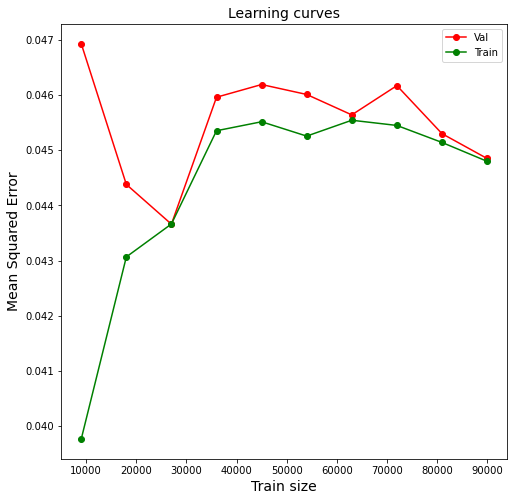

In [74]:
fig = plt.figure(figsize=(8, 8))

plt.plot(train_sizes_bag, -test_scores_bag.mean(1), 'o-', color="r", label="Val")
plt.plot(train_sizes_bag, -train_scores_bag.mean(1), 'o-', color="g", label="Train")
                   
plt.xlabel("Train size",fontsize=14)
plt.ylabel("Mean Squared Error",fontsize=14)
plt.title('Learning curves',fontsize=14)
plt.legend(loc="best")
#plt.ylim(0,200)
#plt.xscale('log')
#plt.yscale('log')

We definitely have enough points

### Boosting

In [82]:
gradboost_clf = GradientBoostingClassifier()
gradboost_clf.fit(X_train,y_train[:,0])

y_pred_gradboost = gradboost_clf.predict(X_test)
y_prob_gradboost = gradboost_clf.predict_proba(X_test)

##### Accuracy of the classification

In [83]:
completeness_gradboost, contamination_gradboost = astroML.utils.completeness_contamination(y_pred_gradboost, y_test[:,0])

print("completeness", completeness_gradboost)
print("contamination", contamination_gradboost)

completeness 0.8562570462232244
contamination 0.09286354135562855


In [84]:
accuracy_gradboost = accuracy_score(y_test[:,0],y_pred_gradboost)

print('accuracy grad boost:',accuracy_gradboost)

accuracy grad boost: 0.96716


In [85]:
confusion_matrix(y_test[:,0],y_pred_gradboost)

array([[21141,   311],
       [  510,  3038]], dtype=int64)

Without any hyperparameter tuning this method gives the higher accuracy I was able to obtain. This is probably because it is very similar to the NN principle of functioning.

### Comparing classifiers: ROC curves

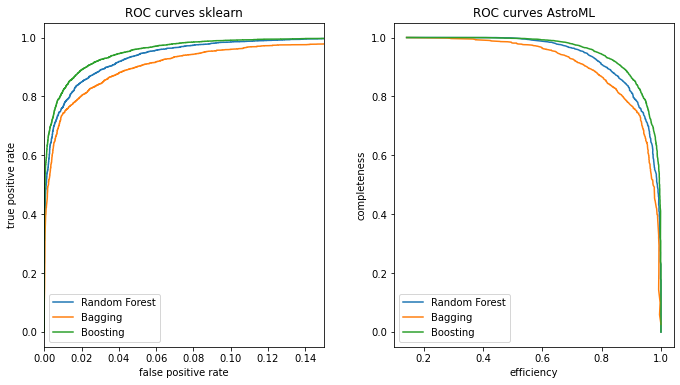

In [86]:
methods_clf = np.array(['Random Forest','Bagging','Boosting'])
y_probs = np.array([y_prob_rf,y_prob_bag,y_prob_gradboost])

#plot
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)
    
# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

for label, y_prob in zip(methods_clf,y_probs):
    # sklearn
    fpr, tpr, thresh = roc_curve(y_test, y_prob[:,1])
    
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    #astroML
    thresholds = np.linspace(0, 1, 1001)[:-1] # grid of thresholds
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob[:,-1] >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test[:,0])
        
    
    # ROC curves sklearn
    ax1.plot(fpr,tpr,label=label)
    #plt.xscale('log')
    ax1.set_xlim(0,0.15)
    ax1.set_xlabel('false positive rate')
    ax1.set_ylabel('true positive rate')
    ax1.set_title('ROC curves sklearn')
    ax1.legend()
    
    ax2.plot(1-cont, comp,label=label)
    ax2.set_title('ROC curves AstroML')
    ax2.set_xlabel('efficiency')
    ax2.set_ylabel('completeness')
    ax2.legend()

### The best I could do...

Together with Alberto Vecchio and Geraint Prattent, I tackled this classification problem with deep-learning: [arXiv:2007.06585](https://arxiv.org/abs/2007.06585). Next time we look into deep learning.

In the paper we reached an accuracy (true positive + true negative / total) of $98.4\%$. The data you're using are those of the green curve in Fig 2. Could you do better? If yes, please tell me how!

I should have really put a figure with my ROC in that paper but I didn't! Deep learning people liked the accuracy and I just went with the flow.


### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance? 

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 



### PCA 

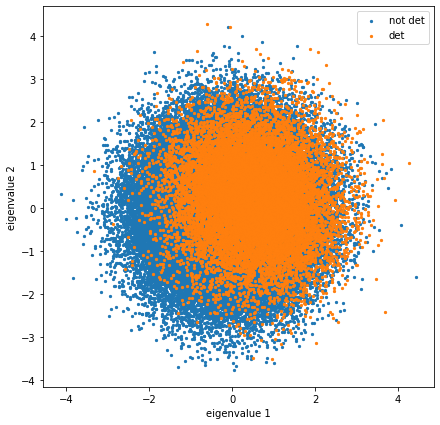

In [87]:
# rescale the dataset for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(0.95) # ask for the number of components explaining 95% of the variance
pca.fit(X_scaled,y[:,0])

X_transformed = pca.transform(X_scaled)

detectability = data[keys=='det'].T[:,0]
det_idx = (detectability==1)
not_det_idx = (detectability==0)

#plot
fig = plt.figure(figsize=(7,7))

for i,cl,lab in zip(range(2),np.array([not_det_idx,det_idx]),np.array(['not det','det'])):
    plt.scatter(X_transformed[:,0][cl],X_transformed[:,1][cl],color='C%i'%i,label=lab,s=5)
    
plt.xlabel('eigenvalue 1')
plt.ylabel('eigenvalue 2')
plt.legend()

In [88]:
evals = pca.explained_variance_ratio_

print('Explained variance ratio by 2 components:',np.sum(evals[:2]),'%','\n')
print('Single components contribution:',evals,'%','\n')

print('Number of components needed to explain 95% of the variance:',len(pca.components_),'\n')

Explained variance ratio by 2 components: 0.15612775741351034 % 

Single components contribution: [0.07816908 0.07795868 0.07773811 0.07748277 0.07725479 0.07705417
 0.07700429 0.07677474 0.07645101 0.07629803 0.07618015 0.07606694
 0.07556725] % 

Number of components needed to explain 95% of the variance: 13 



Text(0.5, 1.0, 'Variance embedded in the cumulative PCA components')

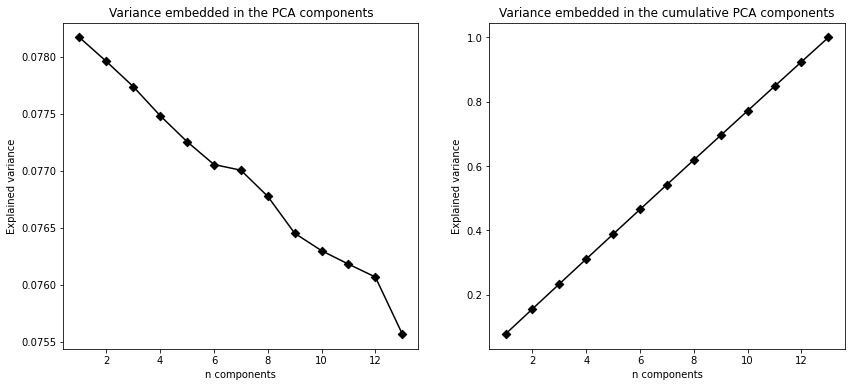

In [89]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,6))

ax[0].plot(np.arange(1,len(evals)+1),evals,color='black')
ax[0].scatter(np.arange(1,len(evals)+1),evals,color='black',marker='D')
ax[0].set_xlabel('n components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Variance embedded in the PCA components')

ax[1].plot(np.arange(1,len(evals)+1),np.cumsum(evals),color='black')
ax[1].scatter(np.arange(1,len(evals)+1),np.cumsum(evals),color='black',marker='D')
ax[1].set_xlabel('n components')
ax[1].set_ylabel('Explained variance')
ax[1].set_title('Variance embedded in the cumulative PCA components')

So the PCA is not helpful, but try the same to see if we are able to improve our classifier: I will perform the analysis with Boosting and Random Forest, since they are the two methods giving me the best accuracy above.

In [90]:
# split the data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = sklearn.model_selection.train_test_split(X_transformed,y[:,0],test_size=0.25,train_size=0.75)

###  Boosting

In [91]:
# try to apply the 2 methods giving the best accuracy:
gradboost_clf_pca = GradientBoostingClassifier()
gradboost_clf_pca.fit(X_train_pca,y_train_pca)

y_pred_gradboost_pca = gradboost_clf_pca.predict(X_test_pca)
y_prob_gradboost_pca = gradboost_clf_pca.predict_proba(X_test_pca)

##### Accuracy of the classification

In [92]:
completeness_gradboost_pca, contamination_gradboost_pca = astroML.utils.completeness_contamination(y_pred_gradboost_pca, y_test_pca)

print("completeness", completeness_gradboost_pca)
print("contamination", contamination_gradboost_pca)

completeness 0.4595124684785654
contamination 0.1327340031729244


In [93]:
accuracy_gradboost_pca = accuracy_score(y_test_pca,y_pred_gradboost_pca)

print('accuracy grad boost:',accuracy_gradboost_pca)

accuracy grad boost: 0.9128


In [94]:
confusion_matrix(y_test_pca,y_pred_gradboost_pca)

array([[21180,   251],
       [ 1929,  1640]], dtype=int64)

With Boosting the accuracy is reduced after PCA

### Random Forest

19


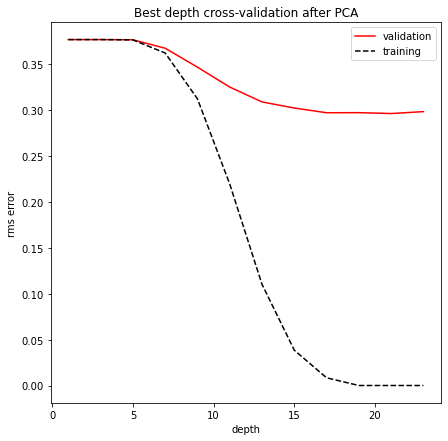

In [95]:
depth = np.arange(1,25)[::2]

rms_val_pca = np.zeros(len(depth))
rms_train_pca = np.zeros(len(depth))

for d,i in zip(depth,np.arange(len(depth))):
    n_splits = 5
    split_method = KFold(n_splits)
    
    model = RandomForestClassifier(n_estimators=100,max_depth=d,random_state=0,n_jobs=-1)
    
    rms_train_pca[i],rms_val_pca[i] = cross_validation(X_train_pca,y_train_pca,model,split_method) # CV only on the training set

best_depth_pca = depth[np.argmin(rms_val_pca)]
print(best_depth)

fig = plt.figure(figsize=(7,7))

plt.plot(depth,rms_val_pca,label='validation',color='red')
plt.plot(depth,rms_train_pca,label='training',color='black',ls='--')
plt.ylabel('rms error')
plt.xlabel('depth')
plt.title('Best depth cross-validation after PCA')
plt.legend()

I will take the depth=15, since it is where it reaches the plateau.

In [96]:
clf_rf_pca = RandomForestClassifier(n_estimators=100,max_depth=15, random_state=0)
clf_rf_pca.fit(X_train_pca,y_train_pca)

y_pred_rf_pca = clf_rf_pca.predict(X_test_pca)
y_prob_rf_pca = clf_rf_pca.predict_proba(X_test_pca)

##### Accuracy of the classification

In [97]:
completeness_rf_pca, contamination_rf_pca = astroML.utils.completeness_contamination(y_pred_rf_pca, y_test_pca)

print("completeness", completeness_rf_pca)
print("contamination", contamination_rf_pca)

completeness 0.43765760717287755
contamination 0.11751412429378531


In [98]:
accuracy_rf_pca = accuracy_score(y_test_pca,y_pred_rf_pca)

print('accuracy random forest:',accuracy_rf_pca)

accuracy random forest: 0.9114


In [99]:
confusion_matrix(y_test_pca,y_pred_rf_pca)

array([[21223,   208],
       [ 2007,  1562]], dtype=int64)

As expected, in both cases the accuracy is worst than in the case without PCA. 

### Regression on SNR

In [100]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF,ConstantKernel

In [101]:
y_reg = data[keys=='snr'].T[:,0]
y_reg.shape

(100000,)

In [102]:
# split the sample:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = sklearn.model_selection.train_test_split(X,y_reg,test_size=0.25,train_size=0.75)

19


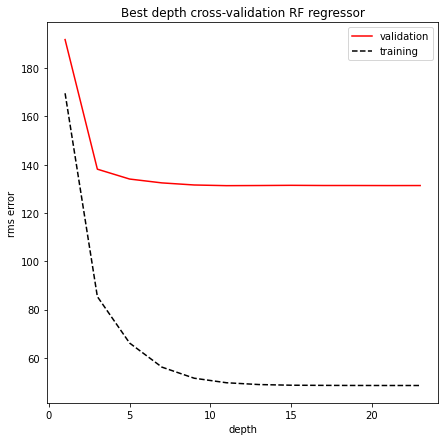

In [103]:
# cross validation to determine the best depth

depth = np.arange(1,25)[::2]

rms_val_reg = np.zeros(len(depth))
rms_train_reg = np.zeros(len(depth))

for d,i in zip(depth,np.arange(len(depth))):
    n_splits = 5
    split_method = KFold(n_splits)
    
    model = RandomForestRegressor(n_estimators=100,max_depth=d,random_state=0,n_jobs=-1)
    
    rms_train_reg[i],rms_val_reg[i] = cross_validation(X_train_reg,y_train_reg,model,split_method) # CV only on the training set

best_depth_reg = depth[np.argmin(rms_val_reg)]
print(best_depth)

fig = plt.figure(figsize=(7,7))

plt.plot(depth,rms_val_reg,label='validation',color='red')
plt.plot(depth,rms_train_reg,label='training',color='black',ls='--')
plt.ylabel('rms error')
plt.xlabel('depth')
plt.title('Best depth cross-validation RF regressor')
plt.legend()

After $depth=5$ er have a plateau of the CV error

In [104]:
rf_reg = RandomForestRegressor(n_estimators=100,max_depth=5, random_state=0)
rf_reg.fit(X_train_reg,y_train_reg)

y_pred_rf_reg = rf_reg.predict(X_test_reg)

In [105]:
# threshold on the detectability:
pred_det_mask = y_pred_rf_reg>=12
test_det_mask = y_test_reg>=12

# build the arrays
y_pred_reg_det = np.zeros(len(y_pred_rf_reg))
y_test_det_reg = np.zeros(len(y_test_reg))

y_pred_reg_det[pred_det_mask] = 1
y_test_det_reg[test_det_mask] = 1

##### Accuracy of the regression

In [106]:
completeness_rf_reg, contamination_rf_reg = astroML.utils.completeness_contamination(y_pred_reg_det, y_test_det_reg)

print("completeness", completeness_rf_reg)
print("contamination", contamination_rf_reg)

completeness 0.6333333333333333
contamination 0.12307692307692308


In [107]:
accuracy_rf_reg = accuracy_score(y_test_det_reg,y_pred_reg_det)

print('accuracy random forest:',accuracy_rf_reg)

accuracy random forest: 0.9344


In [108]:
confusion_matrix(y_test_det_reg,y_pred_reg_det)

array([[21080,   320],
       [ 1320,  2280]], dtype=int64)

Also in this case the accuracy of the classification through regression on the SNR, I wasn't able to improve the accuracy previously achieved through Random Forest Classification or through Boosting.

Let's try to implement a basic neural network through sklearn.

### Neural Network approach

In [109]:
from sklearn.neural_network import MLPClassifier

#### Cross-validation to determine the best number of layers and the best learning rate

Let's now try to cross-validate the neural network playing with the number of layers and neurons per layer and with the learning rate. The other hyperparameters of the neural network will be:

- solver: 'adam'
- activation function: 'logistic' 
- learning rate: 'constant'

In [110]:
# define the NN classifier
clf_grid = MLPClassifier(random_state=1, max_iter=5000)

# define the grid of layers and learning rates:
n_layers = np.array([(10),(5,2),(6,4,2)],dtype=object)
learn_rates = np.array([0.00001,0.0001,0.001,0.01,1,10])

grid = GridSearchCV(clf_grid, param_grid={'hidden_layer_sizes': n_layers, 'learning_rate_init':learn_rates}, cv=5, n_jobs=-1) 

grid.fit(X_train,y_train[:,0])
 

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=5000, random_state=1),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': array([10, (5, 2), (6, 4, 2)], dtype=object),
                         'learning_rate_init': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e+00, 1.e+01])})

In [111]:
best_rate = grid.best_params_['learning_rate_init']
best_layer = grid.best_params_['hidden_layer_sizes']     
print('best N_layers:',best_layer)
print('best learning rate:',best_rate)

best N_layers: (6, 4, 2)
best learning rate: 0.0001


In [112]:
best_nn = MLPClassifier(hidden_layer_sizes=best_layer,learning_rate_init=best_rate,
                         learning_rate='constant',solver='adam',activation='logistic',
                         random_state=1, max_iter=5000)

best_nn.fit(X_train, y_train[:,0])
y_pred_nn = best_nn.predict(X_test)

In [113]:
accuracy_nn = accuracy_score(y_test,y_pred_nn)
print('Accuracy neural network:',accuracy_nn)

Accuracy neural network: 0.963


Also with the neural network I wasn't able to improve the accuracy achieved at the beginnning